In [1]:
# Written by Hippolyte Bourel
# This code is proposed as a reference solution for various exercises of Home Assignements for the OReL course in 2024.
# This solution is tailored for simplicity of understanding and is in no way optimal, nor the only way to implement the different elements!
import numpy as np


# A simple riverswim implementation with chosen number of state 'nS' chosen in input.
# We arbitrarily chose the action '0' = 'go to the left' thus '1' = 'go to the right'.
# Finally the state '0' is the leftmost, 'nS - 1' is the rightmost.


In [2]:
class riverswim():
	def __init__(self, nS):
		self.nS = nS
		self.nA = 2

		# We build the transitions matrix P, and its associated support lists.
		self.P = np.zeros((nS, 2, nS))
		self.support = [[[] for _ in range(self.nA)] for _ in range(self.nS)]
		for s in range(nS):
			if s == 0:
				self.P[s, 0, s] = 1
				self.P[s, 1, s] = 0.6
				self.P[s, 1, s + 1] = 0.4
				self.support[s][0] += [0]
				self.support[s][1] += [0, 1]
			elif s == nS - 1:
				self.P[s, 0, s - 1] = 1
				self.P[s, 1, s] = 0.6
				self.P[s, 1, s - 1] = 0.4
				self.support[s][0] += [s - 1]
				self.support[s][1] += [s - 1, s]
			else:
				self.P[s, 0, s - 1] = 1
				self.P[s, 1, s] = 0.55
				self.P[s, 1, s + 1] = 0.4
				self.P[s, 1, s - 1] = 0.05
				self.support[s][0] += [s - 1]
				self.support[s][1] += [s - 1, s, s + 1]
		
		# We build the reward matrix R.
		self.R = np.zeros((nS, 2))
		self.R[0, 0] = 0.05
		self.R[nS - 1, 1] = 1

		# We (arbitrarily) set the initial state in the leftmost position.
		self.s = 0

	# To reset the environment in initial settings.
	def reset(self):
		self.s = 0
		return self.s

	# Perform a step in the environment for a given action. Return a couple state, reward (s_t, r_t).
	def step(self, action):
		new_s = np.random.choice(np.arange(self.nS), p=self.P[self.s, action])
		reward = self.R[self.s, action]
		self.s = new_s
		return new_s, reward

In [3]:
# A example of application: running the policy "go to the right" for 10 steps and print the sequence of states.
env = riverswim(4)
l = [0] # Initial state arbitrarily set at 0 in the class above.
for _ in range(10):
	l.append(env.step(1)[0])
print("Sequence of states = ", l)

Sequence of states =  [0, np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(2)]


Step 0: Q-values:
 [[0.         0.07490802]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]
Step 0: Policy:
 [1 0 0 0]
Step 100000: Q-values:
 [[ 0.         26.32691934]
 [25.70857154  0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]]
Step 100000: Policy:
 [1 0 0 0]
Step 200000: Q-values:
 [[ 0.         26.28070847]
 [25.66460788  0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]]
Step 200000: Policy:
 [1 0 0 0]
Step 300000: Q-values:
 [[ 0.         26.23764368]
 [25.7390247   0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]]
Step 300000: Policy:
 [1 0 0 0]
Step 400000: Q-values:
 [[ 0.         26.49015882]
 [25.93159401  0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]]
Step 400000: Policy:
 [1 0 0 0]
Step 500000: Q-values:
 [[ 0.         26.36951926]
 [25.73997572  0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]]
Step 500000: Policy:
 [1 0 0 0]
Step 600000: Q-values:
 [[ 0

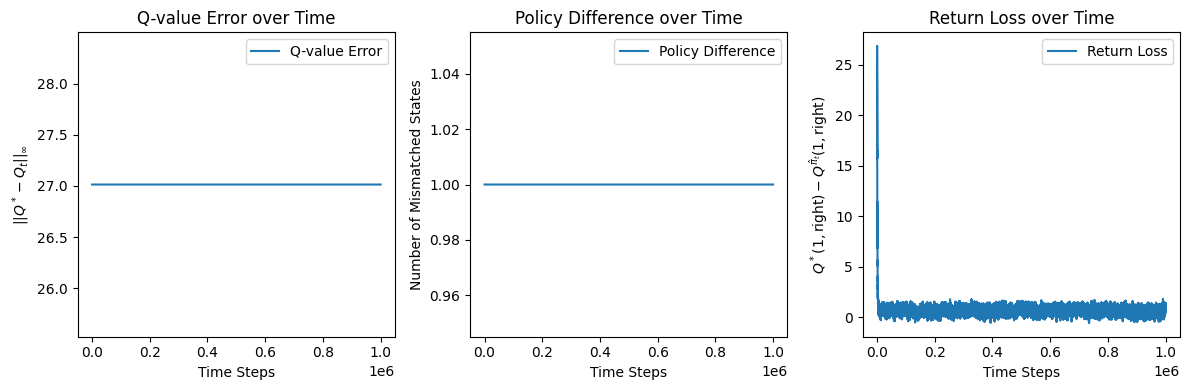

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def q_value_iteration(env, gamma=0.98, tol=1e-6):
    """Computes optimal Q-values using Q-value Iteration (QVI)."""
    Q = np.zeros((env.nS, env.nA))
    delta = float('inf')

    while delta > tol:
        delta = 0
        Q_new = np.copy(Q)
        for s in range(env.nS):
            for a in range(env.nA):
                Q_new[s, a] = sum(env.P[s, a, s_next] * (env.R[s, a] + gamma * np.max(Q[s_next])) for s_next in range(env.nS))
                delta = max(delta, abs(Q[s, a] - Q_new[s, a]))
        Q = Q_new

    policy = np.argmax(Q, axis=1)
    return Q, policy

def ce_opo(env, alpha=0.1, gamma=0.98, horizon=10**6, m=1000):
    """Runs CE-OPO with Q-value Iteration (QVI) updates every m steps."""
    Q = np.zeros((env.nS, env.nA))
    policy = np.zeros(env.nS, dtype=int)
    
    # Compute optimal Q-values and policy
    Q_opt, optimal_policy = q_value_iteration(env)

    error_list = []
    policy_diff_list = []
    return_loss_list = []

    for t in range(horizon):
        state = env.s
        action = optimal_policy[state]  # Use behavioral policy
        next_state, reward = env.step(action)

        # Q-value update with **increased alpha for testing**
        Q[state, action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])

        # Policy update every m iterations
        if t % m == 0 or t == horizon - 1:
            Q_opt, optimal_policy = q_value_iteration(env)
            policy = np.argmax(Q, axis=1)  # Update policy directly from learned Q-values

        env.s = next_state

        # **Debugging Printouts**
        if t % (horizon // 10) == 0:  # Print every 10% of training
            print(f"Step {t}: Q-values:\n", Q)
            print(f"Step {t}: Policy:\n", policy)

        # Compute error metrics dynamically
        q_value_error = np.max(np.abs(Q - Q_opt))
        policy_diff = sum(policy[s] != optimal_policy[s] for s in range(env.nS))
        return_loss = Q_opt[0, 1] - Q[state, action]

        error_list.append(q_value_error)
        policy_diff_list.append(policy_diff)
        return_loss_list.append(return_loss)

    return Q, policy, error_list, policy_diff_list, return_loss_list

# Run CE-OPO with QVI
Q_learned, policy_learned, error_list, policy_diff_list, return_loss_list = ce_opo(env, m=1000)

# Generate plots
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(error_list, label="Q-value Error")
plt.title("Q-value Error over Time")
plt.xlabel("Time Steps")
plt.ylabel(r"$||Q^* - Q_t||_\infty$")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(policy_diff_list, label="Policy Difference")
plt.title("Policy Difference over Time")
plt.xlabel("Time Steps")
plt.ylabel("Number of Mismatched States")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(return_loss_list, label="Return Loss")
plt.title("Return Loss over Time")
plt.xlabel("Time Steps")
plt.ylabel(r"$Q^*(1, \text{right}) - Q^{\hat{\pi}_t}(1, \text{right})$")
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
env.R[0, 1] = np.random.uniform(0, 2)

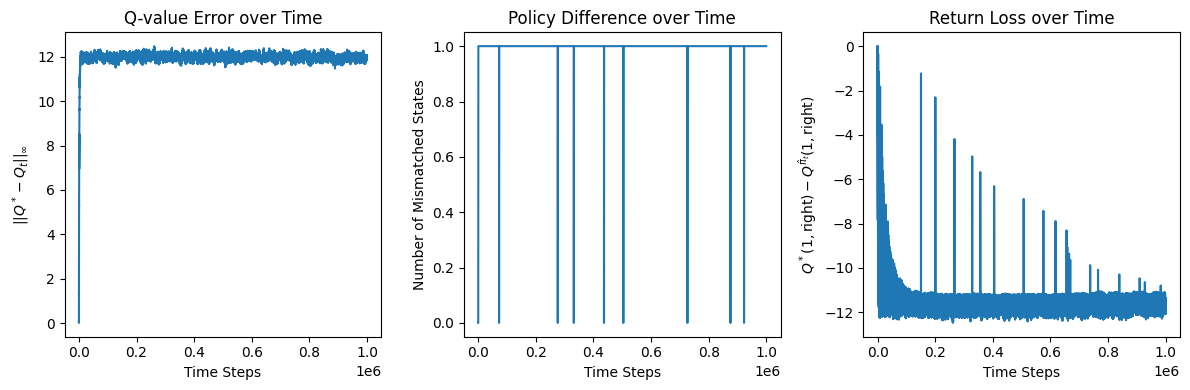

In [9]:
# Run CE-OPO to obtain error metrics
Q_learned, policy_learned, error_list, policy_diff_list, return_loss_list = ce_opo(env)

# Plot Q-value error over time
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(error_list)
plt.title("Q-value Error over Time")
plt.xlabel("Time Steps")
plt.ylabel(r"$||Q^* - Q_t||_\infty$")

# Plot policy difference over time
plt.subplot(1, 3, 2)
plt.plot(policy_diff_list)
plt.title("Policy Difference over Time")
plt.xlabel("Time Steps")
plt.ylabel("Number of Mismatched States")

# Plot return loss over time
plt.subplot(1, 3, 3)
plt.plot(return_loss_list)
plt.title("Return Loss over Time")
plt.xlabel("Time Steps")
plt.ylabel(r"$Q^*(1, \text{right}) - Q^{\hat{\pi}_t}(1, \text{right})$")

plt.tight_layout()
plt.show()

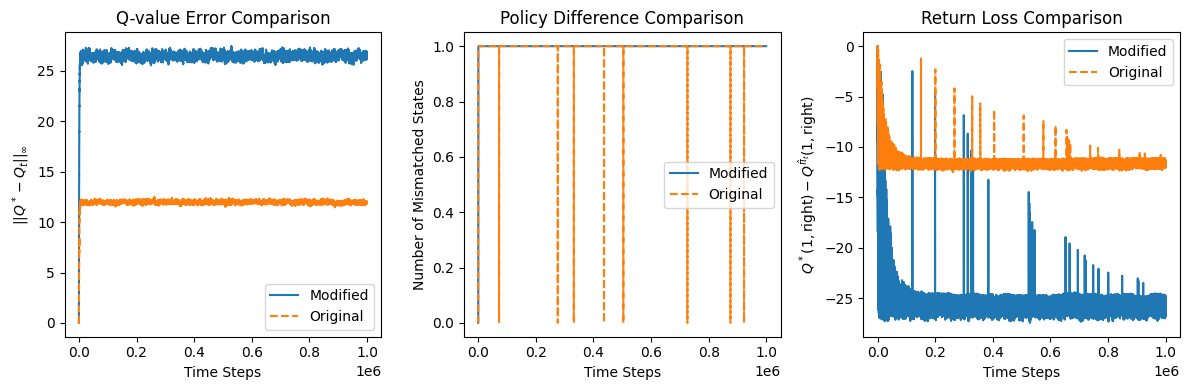

In [10]:
# Modify the reward function for Task 2.ii (Uniform Reward in State L)
np.random.seed(42)  # For reproducibility
env.R[0, 1] = np.random.uniform(0, 2)  # Modify reward for action 'right' at state L

# Run CE-OPO again with modified rewards
Q_learned_mod, policy_learned_mod, error_list_mod, policy_diff_list_mod, return_loss_list_mod = ce_opo(env)

# Plot results for modified RiverSwim
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(error_list_mod, label="Modified")
plt.plot(error_list, label="Original", linestyle="dashed")
plt.title("Q-value Error Comparison")
plt.xlabel("Time Steps")
plt.ylabel(r"$||Q^* - Q_t||_\infty$")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(policy_diff_list_mod, label="Modified")
plt.plot(policy_diff_list, label="Original", linestyle="dashed")
plt.title("Policy Difference Comparison")
plt.xlabel("Time Steps")
plt.ylabel("Number of Mismatched States")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(return_loss_list_mod, label="Modified")
plt.plot(return_loss_list, label="Original", linestyle="dashed")
plt.title("Return Loss Comparison")
plt.xlabel("Time Steps")
plt.ylabel(r"$Q^*(1, \text{right}) - Q^{\hat{\pi}_t}(1, \text{right})$")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
Phi = lambda s: s / 2
for s in range(env.nS):
    for a in range(env.nA):
        env.R[s, a] += sum(env.P[s, a, s_next] * (gamma * Phi(s_next) - Phi(s)) for s_next in range(env.nS))